In [1]:
import os
import pathlib
import time
import zipfile
import tarfile

import imageio
from matplotlib import cm
import matplotlib.pyplot as plt
import numpy as np
import pickle
import time
from PIL import Image
import requests
import scipy.ndimage as ndimage
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_datasets as tfds
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Activation, BatchNormalization
from tensorflow.keras.layers import Conv2D, Dense, Dropout, GaussianNoise
from tensorflow.keras.layers import Flatten, Input, MaxPooling2D, LeakyReLU
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.regularizers import L1, L2
from tensorflow.keras.callbacks import EarlyStopping, LambdaCallback, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.utils import normalize
import tqdm
from sklearn.model_selection import train_test_split
import pandas as pd

2024-05-03 16:49:13.828807: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-03 16:49:13.876084: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-03 16:49:13.876117: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-03 16:49:13.877281: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-03 16:49:13.884569: I tensorflow/core/platform/cpu_feature_guar

In [2]:
#!unzip -o ./tf_data.zip;


In [3]:
working_dir = pathlib.Path().absolute()
# Uncomment line below to debug if images don't show
#print(working_dir)
os.chdir(working_dir)


In [4]:
# RUN THIS CELL

# Enable/Disable Eager Execution
# Reference: https://www.tensorflow.org/guide/eager
# TensorFlow's eager execution is an imperative programming environment
# that evaluates operations immediately, without building graphs

print(f"tensorflow version {tf.__version__}")
print(f"Eager Execution Enabled: {tf.executing_eagerly()}\n")

devices = tf.config.get_visible_devices()
print(f"All Devices: \n{devices}\n")
print(f"Available GPUs: \n{tf.config.list_logical_devices('GPU')}\n")

# Better performance with the tf.data API
# Reference: https://www.tensorflow.org/guide/data_performance
AUTOTUNE = tf.data.AUTOTUNE

tf.random.set_seed(2266)

tensorflow version 2.15.0
Eager Execution Enabled: True

All Devices: 
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Available GPUs: 
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]



2024-05-03 16:49:17.044443: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-03 16:49:17.054289: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-03 16:49:17.057264: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [5]:
df = pd.read_csv('data/undersampled_top_10.csv')
X = []
y = []
df_efficient = df.set_index('catalogNumber')
df_efficient.head(5)

,Unnamed: 0,gbifID,references,basisOfRecord,sex,lifeStage,behavior,eventTime,month,continent,countryCode,verbatimElevation,decimalLatitude,decimalLongitude,mediaType,genus,species
catalogNumber,,,,,,,,,,,,,,,,,
XC361568,117,2243757996,https://data.biodiversitydata.nl/xeno-canto/ob...,HUMAN_OBSERVATION,NaN,NaN,flight call,6:07:00 PM,3.0,EUROPE,DE,260 m,48.9870,9.0108,Sound;StillImage;StillImage,Loxia,Loxia curvirostra
XC361676,122,2243757192,https://data.biodiversitydata.nl/xeno-canto/ob...,HUMAN_OBSERVATION,NaN,NaN,call,5:30:00 PM,3.0,EUROPE,GR,40 m,36.8217,21.9273,StillImage;StillImage;Sound,Sylvia,Sylvia atricapilla
XC361991,137,3909408313,https://data.biodiversitydata.nl/xeno-canto/ob...,HUMAN_OBSERVATION,NaN,NaN,call,10:00:00 AM,3.0,EUROPE,NL,0 m,52.3568,4.5675,StillImage;StillImage;Sound,Fringilla,Fringilla coelebs
XC362620,162,2243759376,https://data.biodiversitydata.nl/xeno-canto/ob...,HUMAN_OBSERVATION,NaN,NaN,"call, sweeoo call",2:27:00 PM,4.0,EUROPE,DE,300 m,49.0102,8.8949,Sound;StillImage;StillImage,Phylloscopus,Phylloscopus collybita
XC363724,205,2243761271,https://data.biodiversitydata.nl/xeno-canto/ob...,HUMAN_OBSERVATION,NaN,NaN,"call, imitation",7:30:00 AM,4.0,EUROPE,PL,160 m,53.1490,20.2591,Sound;StillImage;StillImage,Parus,Parus major


In [ ]:
test_dataset = tf.data.Dataset.load('tf_data/test_data')
train_dataset = tf.data.Dataset.load('tf_data/train_data')
val_dataset = tf.data.Dataset.load('tf_data/validation_data')

In [7]:
def normalize_image(img):
    return tf.cast(img, tf.float32)/255.

def preprocess(img, label):
    return normalize_image(img), label

train_dataset = train_dataset.map(preprocess).batch(32).prefetch(tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.map(preprocess).batch(32).prefetch(tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.map(preprocess).batch(32).prefetch(tf.data.experimental.AUTOTUNE)

We first normalize each image by setting each pixel value to between 0 and 1, and then batch the data into batches of size 32.

In [8]:
Piczak_model_2 = Sequential([
    # First convolutional layer with 80 filters
    Conv2D(80, kernel_size=(128, 6), padding='same', input_shape=(128, 431, 1)),
    LeakyReLU(alpha=0.3),

    # Max pooling
    MaxPooling2D(pool_size=(4, 6)),

    # Second convolutional layer with 160 filters
    Conv2D(160, kernel_size=(1, 2), padding='same'),
    LeakyReLU(alpha=0.3),

    # Max pooling
    MaxPooling2D(pool_size=(1, 2)),

    # Continue the pattern...
    Conv2D(240, kernel_size=(1, 2), padding='same'),
    LeakyReLU(alpha=0.3),
    MaxPooling2D(pool_size=(1, 2)),

    Conv2D(320, kernel_size=(1, 2), padding='same'),
    LeakyReLU(alpha=0.3),
    MaxPooling2D(pool_size=(1, 2)),

    # Flatten the output of the conv layers to connect it with dense layers
    Flatten(),

    # Dropout layer
    Dropout(0.5),

    # Output layer with softmax activation
    Dense(10, activation='softmax', kernel_regularizer=L2(0.001))
])

Piczak_model_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 431, 80)      61520     
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 128, 431, 80)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 71, 80)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 71, 160)       25760     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 32, 71, 160)       0         
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 32, 35, 160)       0         
 g2D)                                                   

We use a similar CNN model to the one defined by [Piczak](https://ceur-ws.org/Vol-1609/16090534.pdf). The initial CNN layer has a kernel size that is the height of the input image; this is because the image is not invariant vertically, as higher locations in the image mean higher frequencies. Thus, the kernel is only allowed to move left and right; in essence, audio data is time invariant (we would expect a sound that occurs later to be the same as a sound that occurs earlier), but it is not frequency invariant. We made the CNN deep so that it would learn more complex features, which we expect to be necessary for processing something as complicated as an audio spectrogram. The dropout layer before the final classification output is to avoid overfitting.

In [9]:
Piczak_model_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
es = EarlyStopping(monitor="val_loss", patience=3)
history = Piczak_model_2.fit(train_dataset, epochs=20, validation_data = val_dataset, callbacks=[es])


Epoch 1/20


2024-05-03 16:49:19.753134: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8906
2024-05-03 16:49:20.031054: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-05-03 16:49:21.517651: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-05-03 16:49:22.161494: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fe6b46d9cc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-05-03 16:49:22.161543: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2024-05-03 16:49:22.167602: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1714754962.273979     789 device_compiler.h:186] Compiled

2303/2303 [==============================] - 592s 254ms/step - loss: 1.3604 - accuracy: 0.6174 - val_loss: 1.1324 - val_accuracy: 0.7257
Epoch 2/20
2303/2303 [==============================] - 584s 254ms/step - loss: 1.1134 - accuracy: 0.7395 - val_loss: 1.0411 - val_accuracy: 0.7679
Epoch 3/20
2303/2303 [==============================] - 585s 254ms/step - loss: 1.0542 - accuracy: 0.7677 - val_loss: 1.0024 - val_accuracy: 0.7930
Epoch 4/20
2303/2303 [==============================] - 586s 255ms/step - loss: 1.0336 - accuracy: 0.7805 - val_loss: 0.9880 - val_accuracy: 0.8041
Epoch 5/20
2303/2303 [==============================] - 586s 254ms/step - loss: 1.0229 - accuracy: 0.7902 - val_loss: 0.9927 - val_accuracy: 0.8105
Epoch 6/20
2303/2303 [==============================] - 586s 254ms/step - loss: 1.0060 - accuracy: 0.8008 - val_loss: 0.9926 - val_accuracy: 0.8133
Epoch 7/20
2303/2303 [==============================] - 588s 255ms/step - loss: 1.0051 - accuracy: 0.8068 - val_loss: 1.045

In [10]:
Piczak_model_2.save_weights('baseline.h5')
with open('baseline_history', 'wb') as file_pi:
    pickle.dump(history, file_pi)

In [11]:
def plot_hist(model, title=None):
    fig, axs = plt.subplots(1,2, figsize=(12,5))
    axs[0].plot(model.history['loss'], label='train')
    axs[0].plot(model.history['val_loss'], label='val')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('CE Loss')
    axs[0].set_title('Loss')
    axs[0].legend()
    axs[1].plot(model.history['accuracy'], label='train')
    axs[1].plot(model.history['val_accuracy'], label='val')
    axs[1].set_title('Accuracy')
    axs[1].legend()
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('ACC')
    plt.suptitle(title)

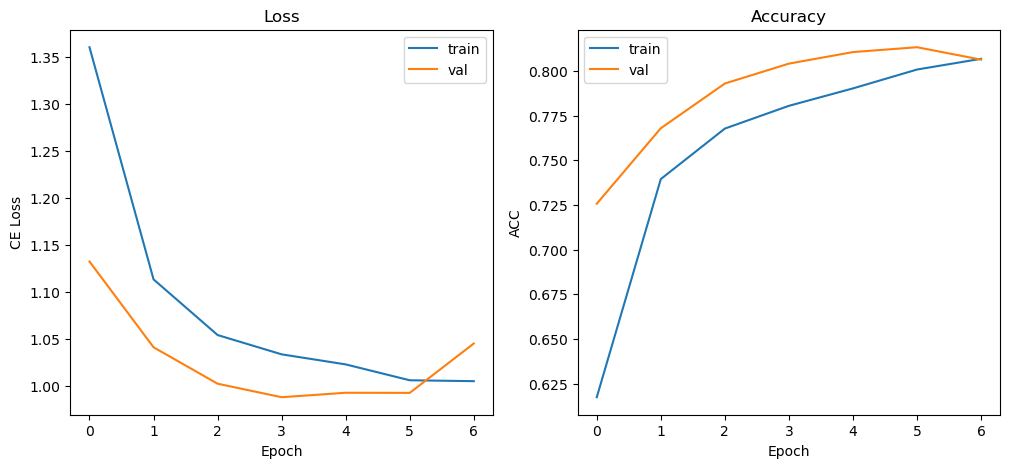

In [12]:
plot_hist(history)

The history shows that after epoch 3, we are likely overfitting. The early stopping callback ensures that our model weights are restored to the weights after epoch 3. Our validation accuracy hovers around 0.8.

In [13]:
test_loss, test_accuracy = Piczak_model_2.evaluate(test_dataset, verbose=1)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

720/720 [==============================] - 90s 125ms/step - loss: 1.0343 - accuracy: 0.8088
Test Loss: 1.034346103668213
Test Accuracy: 0.8087813854217529


We can see that our baseline model already performs quite well. A test accuracy of 0.8 for 10 species greatly outperforms our original model from MS4 (0.3 accuracy) due to the higher quality and amount of data.